In [117]:
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import nibabel as nib
import numpy as np
import pandas
import os
import glob



### The Task FConn-Based Classifier
## Algorithm
1) For subject i, create a labels data set with begin and end TRs for each trial, as well as their accuracy (0 or 1)

2) For each trial, slice the fMRI volumes that were obtained during that trial's window. Include some TRs before and after 

3) For each trial window, apply HO mask and extract ROI time series data. Apply signal cleaning.

4) For subject i, calculate ~ 150 ROIs using seed-based connectivity. Try dictlearn. 

5) Calculate tangent based connectivity, correlation connectivity, and partial correlation connectivity. Remove diagonal and top half of each connectivity matrix

6) Train an SVM non-sparse classifier (l2) on the random 35 Trial FConn matrices. Test on remaining 13. Do this for each connectivity matrix.

7) Train an SVM non-sparse classifier on all connectivity matrices.

8) Repeat previous two steps, but with the Seed-based connectivity from step 4


# Create Trial Labels with Begin & End TRs
First we load in the trial master file, which contains all the trial metadata for each subject from MLINDIV. We also load in a file with the sync pulses for all runs for a specific subject - in this case subject 33. You can view the sync pulse times below. They are in milliseconds, and correspond to when the "Get Ready" indicator during an MLINDIV trial was displayed (Onset Time) and when it ended, starting the first trial (RTTime).

In [2]:
testtrials_filename = 'D:/SampleData/MLINDIV_trial_master.csv'
test_trials = pandas.read_csv(testtrials_filename)

sync_pulses = pandas.read_csv("D:/SampleData/sub-033_syncpulses.csv")
sync_pulses

,subject,trial_type,procedure,getready_onset,getready_response
0,33,1,Explore,9068,22092
1,33,2,Explore,16233,28795
2,33,C1,Test,5906,21758
3,33,C2,Test,5621,16286
4,33,C3,Test,11955,26313
5,33,C4,Test,21605,31584
6,33,C5,Test,5413,28994
7,33,C6,Test,9712,32781


We then define a function that creates a series of trial labels indicating the TRs for when specific trials began and ended, in relation to the sync pulses for that scan run. Subject 33's trial meta-data and sync pulses are then passed to this function, outputting the labeled data set necessary for training the Classifier. These also tell us which time frames to extract from the fmri run to create corresponding Functional Connectivity Matrices from.

In [111]:
def create_trial_labels(subjectnum, sync_pulses):
    # Filter by subject
    test_labels = test_trials[test_trials['Subject'] == subjectnum].copy()
    
    # Initialize Pandas data series for Start and End TRs, as well as for fmri_run number
    start_TR = pandas.Series(dtype = 'float32')
    end_TR = pandas.Series(dtype = 'float32')
    fmri_run = pandas.Series(dtype = 'float32')
    
    # Get order of task type for labeling wich fmri run each entry corresponds too
    time_indices = np.unique(test_labels['times'], return_index = True)[1]
    task_order = []
    [task_order.append(test_labels.iloc[[i]]['Task_type'].to_string().split()[1]) for i in time_indices]
    

    
    
    for i in sync_pulses.index:

        data = test_labels[test_labels['Task_type'] == sync_pulses.trial_type[i]].copy()

        trial_times = np.unique
        start_tr = np.floor((data["trial_starttime"].copy() - sync_pulses.getready_response[i]) / 720).astype(int)
        end_tr = np.floor((data["trial_endtime"].copy() - sync_pulses.getready_response[i]) / 720).astype(int)
        run_num = task_order.index(sync_pulses.trial_type[i])


        start_TR = pandas.concat([start_TR, pandas.Series(start_tr)])
        end_TR = pandas.concat([end_TR, pandas.Series(end_tr)])
        
        if run_num > 1:
            run_num = 'Run' + str(run_num - 1)
        elif run_num == 1:
            run_num = 'Ex2' 
        else:
            run_num = 'Ex'
        fmri_run = pandas.concat([fmri_run, pandas.Series([run_num] * len(end_tr))])
        
        
        
        
    test_labels = test_labels[['Subject', 'Task_type', 'trial_starttime', 'trial_endtime', 'accuracy']]
    
    test_labels['start_TR'] = start_TR.values
    test_labels['end_TR'] = end_TR.values
    test_labels['fmri_run'] = fmri_run.values

    
    return test_labels, task_order

# Run this function on subject 33
sub_033_trial_labels, sub_033_task_order = create_trial_labels(33, sync_pulses)
print(sub_033_task_order)
sub_033_trial_labels

['1', '2', 'C2', 'C6', 'C4', 'C3', 'C1', 'C5']


,Subject,Task_type,trial_starttime,trial_endtime,accuracy,start_TR,end_TR,fmri_run
1405,33,1,22106.0,504785.0,NaN,0,670,Ex
1406,33,2,28811.0,510317.0,NaN,0,668,Ex2
1407,33,C1,26530.0,51207.0,True,6,40,Run5
1408,33,C1,60166.0,89989.0,True,53,94,Run5
1409,33,C1,97135.0,123812.0,True,104,141,Run5
1410,33,C1,133585.0,166701.0,True,155,201,Run5
1411,33,C1,175660.0,207523.0,True,213,258,Run5
1412,33,C1,215402.0,240826.0,True,268,304,Run5
1413,33,C1,249398.0,269356.0,True,316,343,Run5
1414,33,C1,277235.0,310858.0,True,354,401,Run5


In [113]:
np.unique(sub_033_trial_labels[sub_033_trial_labels['fmri_run'] == 'Run1'].Task_type)[0]

'C2'

As you can see above, subject 33 would not be a good subject to train on as they had perfect accuracy. Also, a simple FConn matrix looking at around 20 ROIs gives 180 unique features to train in a classifier ((20^2) / 2 ) - 20). Given a single subject only has 48 test trials, a decent machine learning model would be using around a sixth of the examples as features to learn (180 features trained on ~ 30 features for the train set) and the test set would be fairly small (~15 examples), so it would be prone to overfitting and low training accuracy.

To remedy this, we will ultimately train on multiple subjects data. This generalization can be made under the assumption that functional connectivity between key brain ROIs can predict task performance, and functional networks have already been well established across individuals. 

But for now, we will create a function that extracts functional conenct

# Extract fMRI Time Series for Each Time Window 

Here we will build a function that iterates through an fMRI run and segments out slices based in a begin and end TR -- as indicated by our trial labels created above -- creating a sequence of time windows bounded by the Begin and End TRs of each trial for each run.

Then, for each time window, we will apply an atlas to define regions of interest (ROIs) and create a smoothed BOLD signal time series for each ROI. With these ROI time series for a given test trial, we can then compute a functional conenctivity matrix, and store the values in an array. 


In [99]:
dataset = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels
subject = '043'
mlindiv_filename = "D:/SampleData/func/sub-043/sub-043_task-boldRun1_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
confounds_filename = 'D:/SampleData/confounds/sub-043_task-boldRun1_run-1_conformatted.tsv'
run_name = 'Run1'
task_label = 'C2'

def subject_timeseries(mlindiv_filename, confounds_filename):
    
    # Load fmri volumes
    func_img = nib.load(mlindiv_filename)
    header_zooms = func_img.header.get_zooms()
    TR = header_zooms[3]

    pandas.read_csv(confounds_filename, sep = '\t').fillna(0).to_csv("conf_nona_temp.tsv", sep = '\t', index = False)

    print('Atlas ROIs are located in nifti image (4D) at: %s' % atlas_filename)
    print('Func images are located in nifti image (4D) at: %s \n\t--- Confounds at: %s' % (mlindiv_filename, confounds_filename))
    print('Func images Voxel Dimensions (mm): %s\tFunc TR: %s' % (header_zooms[0:3], header_zooms[3]))

    # Create a masker from the HO atlas
    masker = NiftiLabelsMasker(
        labels_img = atlas_filename, 
        standardize=True, 
        memory = 'nilearn_cache', 
        verbose = 5, low_pass=0.08, high_pass=0.009, detrend=True, t_r = TR)


    # Create an overall time series for the run
    time_series = masker.fit_transform(mlindiv_filename, confounds = 'conf_nona_temp.tsv')
    
    return time_series


In [100]:
sub_043_C2_timeseries = subject_timeseries(mlindiv_filename, confounds_filename)

Atlas ROIs are located in nifti image (4D) at: C:\Users\17868/nilearn_data\fsl\data\atlases\HarvardOxford\HarvardOxford-sub-maxprob-thr25-2mm.nii.gz
Func images are located in nifti image (4D) at: D:/SampleData/func/sub-043/sub-043_task-boldRun1_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz 
	--- Confounds at: D:/SampleData/confounds/sub-043_task-boldRun1_run-1_conformatted.tsv
Func images Voxel Dimensions (mm): (2.0, 2.0, 2.0)	Func TR: 0.72
[NiftiLabelsMasker.fit_transform] loading data from C:\Users\17868/nilearn_data\fsl\data\atlases\HarvardOxford\HarvardOxford-sub-maxprob-thr25-2mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('D:/SampleData/func/sub-043/sub-043_task-boldRun1_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.009,
  'label

What we are left with is a Functional Connectivity Matrix for each Test Trial across all subjects we would like to train. We can then pass these FConn matrices and label them with that trial's accuracy (0 or 1), and train a classifier to predict accuracy given a subject's FConn during a trial.

In [101]:
sub_043_C2_timeseries.shape

(578, 21)

In [127]:
def timewindows(timeseries, trial_labels, task_label, start_padding = 0, end_padding = 0):
    t_labels = trial_labels[trial_labels['Task_type'] == task_label]
    
    time_window_num = t_labels.shape[0]

    
    time_windows = []

    for i in range(time_window_num):
        
        start_TR = t_labels.start_TR.iloc[i] + start_padding
        end_TR = t_labels.end_TR.iloc[i] + end_padding
        
        time_window = timeseries[start_TR:end_TR, :]
        time_windows.append(time_window)
        
    return time_windows

In [146]:
sub043_timewindows = timewindows(sub_043_C2_timeseries, sub_033_trial_labels, task_label)
[print("Run C2 Trial #%d shape: %s" % (i+1, sub043_timewindows[i].shape)) for i in range(len(sub043_timewindows))]


Run C2 Trial #1 shape: (65, 21)
Run C2 Trial #2 shape: (54, 21)
Run C2 Trial #3 shape: (51, 21)
Run C2 Trial #4 shape: (33, 21)
Run C2 Trial #5 shape: (33, 21)
Run C2 Trial #6 shape: (32, 21)
Run C2 Trial #7 shape: (50, 21)
Run C2 Trial #8 shape: (56, 21)


[None, None, None, None, None, None, None, None]

## Now we define a funciton that iterates through each fmri test run and creates a dictionary containing time-windows of time series as values for runs as key

In [172]:
def aggregate_timewindows(subject, func_directory, task_labels, start_padding = 0, end_padding = 0):
    
    # Define list of files to be processed, given subject number and location of functional files.
    directory_path = "%s/sub-%s" % (func_directory, subject)
    trial_filenames = os.listdir(directory_path)
    print("Functional Images for Subject %s stored in %s" % (subject, directory_path))
    print("Functional files to be processed: " + str(trial_filenames))
    
    # Initialize empty Dictionary of Windowed - Time Series
    dict_timewindows = {}
    
    for run in trial_filenames:
        # Grab task label from matching the func run number to trial labels.
        run_name = run.split("bold")[1].split("_")[0]
        task_label = np.unique(task_labels[task_labels['fmri_run'] == run_name].Task_type)[0]
        print("Computing ROI Time Series for %s: %s" % (run_name, task_label))
        
        # Get path to func file and corresponding confounds file
        mlindiv_filename = directory_path+ '/' + run
        confounds_filename = glob.glob("D:/SampleData/confounds/*%s*%s_*.tsv" % (subject, run_name))[0]
        
        # Compute time series for func run
        time_series = subject_timeseries(mlindiv_filename, confounds_filename)
        
        # Split time series into list time windows
        time_windows = timewindows(time_series, trial_labels, task_label, start_padding, end_padding)
        
        # For current Run, assign the list of time windows obtained from the previous line
        dict_timewindows[task_label] = time_windows
    
    return dict_timewindows

In [174]:
sub_num = '043'
test_trials = pandas.read_csv('D:/SampleData/MLINDIV_trial_master.csv')
sync_pulses = pandas.read_csv('D:/SampleData/sub-043_syncpulses.csv')


sub043_TW = aggregate_timewindows(sub_num, 'D:/SampleData/func', trial_labels)


Functional Images for Subject 043 stored in D:/SampleData/func/sub-043
Functional files to be processed: ['sub-043_task-boldEx_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-043_task-boldRun1_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-043_task-boldRun2_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-043_task-boldRun3_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-043_task-boldRun4_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-043_task-boldRun5_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-043_task-boldRun6_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
Computing ROI Time Series for Ex: 1
Atlas ROIs are located in nifti image (4D) at: C:\Users\17868/nilearn_data\fsl\data\atlases\HarvardOxford\HarvardOxford-sub-maxprob-thr25-2mm.nii.gz
Func images are located in nifti image (4D) at: D:/SampleData/func/sub-043/sub-043_task-boldEx_run-1_space-MNI152NLin2009cAsym_desc-prepr

In [218]:
6*8

48

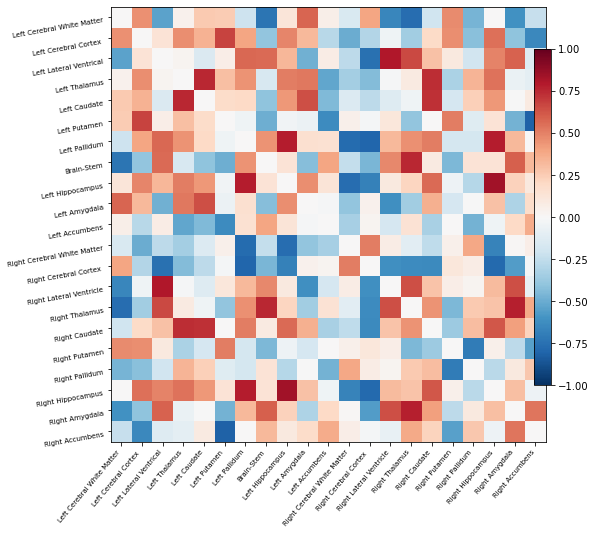

In [215]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([sub043_TW['A2'][1]])[0]

np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=1, vmin=-1, reorder=False)

In [210]:
tt = test_trials[test_trials['Subject'] == 43]
tt = tt[tt['Task_type'] == 'A2']
tt['accuracy'].iloc[2]

True